In [1]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import matplotlib.pyplot 
import Bio
#Neighbour Join Tree
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import matplotlib.pyplot as plt
import Bio.Phylo as Phylo
import os
import Bio.Phylo as Phylo

In [2]:
df_weekly_sum = pd.read_csv('dpgr_who_countries_1.csv')
print(df_weekly_sum)

       Variant                   Date                         Location  Freq
0        Alpha  2019-12-30/2020-01-05  Africa / South Africa / Gauteng     1
1        Alpha  2019-12-30/2020-01-05            Asia / India / Kerala     5
2        Alpha  2019-12-30/2020-01-05        Asia / India / Tamil Nadu     1
3        Alpha  2019-12-30/2020-01-05                          Austria     4
4        Alpha  2019-12-30/2020-01-05                  Europe / Cyprus    21
...        ...                    ...                              ...   ...
83732  Omicron  2022-05-30/2022-06-05                      South Korea     3
83733  Omicron  2022-05-30/2022-06-05                            Spain   177
83734  Omicron  2022-05-30/2022-06-05                           Sweden     6
83735  Omicron  2022-05-30/2022-06-05                      Switzerland    69
83736  Omicron  2022-05-30/2022-06-05                              USA  4135

[83737 rows x 4 columns]


In [3]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
# def create_distance_matrix(df,quarter_continent):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     distance_matrix = pd.DataFrame(index = clade_list)
#     distance_matrix[clade_list] = np.nan
#     #fill in distance matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 distance_matrix.loc[i,j] = 0
#             else:
#                 distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     return distance_matrix

#this distance matrix only selects clades thats within the clade list
def create_distance_matrix(df, quarter_continent, variant_choice_set):
    clade_list = set()
    for variant in df['Variant']:
        clades = variant.split(' vs ')
        clade_list.update(clades)
#         print(clade_list)

    
    clade_list = sorted(clade_list)
    clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
    distance_matrix.fillna(0, inplace=True)

    for i in clade_list:
        for j in clade_list:
            if i != j:
                variant_1 = f"{i} vs {j}"
                variant_2 = f"{j} vs {i}"
                slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
                slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
                slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
                distance_matrix.loc[i, j] = abs(slope)
                distance_matrix.loc[j, i] = abs(slope)

    return distance_matrix


# #function to generate difference matrix based on quarter, year, and continent
# def create_difference_matrix(df,quarter_continent):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     difference_matrix = pd.DataFrame(index = clade_list)
#     difference_matrix[clade_list] = np.nan
#     #fill in difference matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 difference_matrix.loc[i,j] = 0
#             else:
#                 difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     #if row_vs_col is a negative value, make it negative in difference matrix
#     for i,v in difference_matrix.iterrows():
#         for j in difference_matrix:
#             if i != j:
#                 if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
#                     difference_matrix.loc[i,j] *= -1
#     return difference_matrix

#Modifed the distance matrix , here the input is only the generated distance matrix
#function to generate difference matrix based on quarter, year, and continent
# def create_difference_matrix(distance_matrix):
# #     tmp = df['Variant'].str.split('vs', expand=True)
# #     clade_list = tmp[0].unique()
# #     difference_matrix = pd.DataFrame(index = clade_list)
# #     difference_matrix[clade_list] = np.nan
# #     #fill in difference matrix
# #     for i in clade_list:
# #         for j in clade_list:
# #             if i == j:
# #                 difference_matrix.loc[i,j] = 0
# #             else:
# #                 difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
# #                                                         quarter_continent].iloc[0] + 
# #                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                    quarter_continent].iloc[0])/2))
# #                 difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                         quarter_continent].iloc[0] + 
# #                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                    quarter_continent].iloc[0])/2))
#     #if row_vs_col is a negative value, make it negative in difference matrix
# #     for i,v in difference_matrix.iterrows():
# #         for j in difference_matrix:
# #             if i != j:
# #                 if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
# #                     difference_matrix.loc[i,j] *= -1
# #     return difference_matrix

#     difference_matrix = distance_matrix.copy()

#     # Iterate over the rows and columns of the difference_matrix
#     for i, row in difference_matrix.iterrows():
#         for j in difference_matrix.columns:
#             if i != j:
#                 # Check if the row_vs_col value is negative
#                 if distance_matrix.loc[i, j] < 0:
#                     # Set values above the main diagonal to the negative value
#                     difference_matrix.loc[i, j] = -abs(difference_matrix.loc[i, j])
#                     print(difference_matrix)
#                 else:
#                     # Set values below the main diagonal to the positive value
#                     difference_matrix.loc[i, j] = abs(difference_matrix.loc[i, j])
                    
#         return difference_matrix

def create_difference_matrix(distance_matrix):
    difference_matrix = distance_matrix.copy()

    # Iterate over the rows and columns of the difference_matrix
    for i, row in difference_matrix.iterrows():
        for j in difference_matrix.columns:
            if i != j:
                # Check if the row_vs_col value is negative
                if distance_matrix.loc[i, j] < 0:
                    # Set values above the main diagonal to the negative value
                    difference_matrix.loc[i, j] = -abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = abs(difference_matrix.loc[i, j])
                else:
                    # Set values below the main diagonal to the positive value
                    difference_matrix.loc[i, j] = abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = -abs(difference_matrix.loc[i, j])

    return difference_matrix


#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
#     print(f"dataframe after time window:\n {dataframe.head()}")
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

### *Use the automation mine function to create the distance matrix in variant choice set for specific time window*

In [4]:
# This function finds the distance matrix among all the clades 

def automation_mine(country, dataset, start, end, variant_choice_set):
    
    df_weekly = dataset[dataset['Location'] == country]
#     print(df_weekly.head())

    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
    tmp.columns = ['0','1','2','3']

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
#     print(f"df_weekly :\n {df_weekly.head}")
#     print(f"df_weekly : \n {df_weekly.columns}")
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
    # df_sum.to_csv(country+"df_sum"+r'.csv')
#     print(f"df_sum :\n {df_sum}")
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(f" df_ : \n{df_}")
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
#     print(f"df_ :\n {df_}")
#     print(f"df_ :\n {df_.columns}")
    

    #calculate slopes, have to disregard nans
    df_slopes = pd.DataFrame()
    cols = df_.columns.to_list()
    df_slopes['Variant'] = cols[3:]
#     print(df_slopes['Variant'])
    slopes = []
    for i,v in enumerate(df_.iloc[:,3:]):
        tmp = df_[~df_.iloc[:,i+3].isnull()]
        tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
#         print(tmp)
        slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
        #print(len(slopes))
#         print(df_slopes)
    df_slopes['Slope'] = slopes
    # df_slopes.to_csv(country+"_slope_WHO"+r'.csv')
    df_slopes = pd.DataFrame(df_slopes)
#     print(df_slopes)
    
#     dist_mat = create_distance_matrix(df_slopes,'Slope')
#     # dist_mat.to_csv(country+"_dist_mat_WHO"+r'.csv')
#     print(f"distance matrix :\n {dist_mat}")

#     #define the file path
#     file_path = f'/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/{country + "_" + start + "_" + end + "_dist_mat_who_labels"}.csv'

    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
#     dist_mat.to_csv(file_path, index=True)
    print(f"Diatance matrix: \n {dist_mat}")
    
    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
    file_name = f"{country}_{start}_{end}_dist_mat.csv"
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, file_name)
    dist_mat.to_csv(file_path, index=True)
    if os.path.isfile(file_path):
        print(f"Distance matrix saved at: {file_path}")
    else:
        print("Error: Failed to save the distance matrix.")


#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)
    
#     dif_mat = create_difference_matrix(df_slopes,'Slope')
#     # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
#     # print(f"difference matrix :\n {dif_mat}")

#     #Plot distance matrix as clustermap
#     sns.set(rc = {'figure.figsize':(10, 20)}, font_scale = 1.8)

#     #create distance array from distance matrix
#     distance_array = ssd.squareform(dist_mat) 

#     #create linkage object
#     distance_linkage = hierarchy.linkage(distance_array)
#     print(distance_array.shape)
#     print(dist_mat.shape)

#     #display clustermap
#     g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
#                         cmap = 'coolwarm',vmin=-.023,vmax=0.023, cbar_pos=(0.971, 0.087, .03, 0.7))                     
#     # g.fig.set_size_inches(10, 10)
#     # plt.savefig(country+"_clustermap_WHO"+'.jpg', dpi = 300, bbox_inches='tight')
#     return g

In [5]:
# #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})

['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.002825
Beta   0.002825  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2020-12_2021-01_dist_mat.csv


In [6]:
# #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2021-08', end = '2021-09', variant_choice_set= {'Beta', 'Delta'})

['2021-08', '2021-09']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.006088
Delta  0.006088  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-08_2021-09_dist_mat.csv


In [7]:
# #automation function finds the diatance matrix
automation_mine('USA', df_weekly_sum, start = '2022-03', end = '2022-05', variant_choice_set= {'Delta', 'Omicron'})

['2022-03', '2022-04', '2022-05']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.009315
Omicron  0.009315  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2022-03_2022-05_dist_mat.csv


### *Load the distance matrix*

In [8]:
alpha_beta_usa = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2020-12_2021-01_dist_mat.csv', index_col=0)
alpha_beta_usa

,Alpha,Beta
Alpha,0.000000,0.002825
Beta,0.002825,0.000000


In [9]:
beta_delta_usa = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2021-08_2021-09_dist_mat.csv', index_col= 0)
beta_delta_usa

,Beta,Delta
Beta,0.000000,0.006088
Delta,0.006088,0.000000


In [10]:
delta_omicron_usa = pd.read_csv('/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/USA_2022-03_2022-05_dist_mat.csv', index_col=0)
delta_omicron_usa

,Delta,Omicron
Delta,0.000000,0.009315
Omicron,0.009315,0.000000


### *Combine the distance matrices and plot the heatmap for getting the combined distance matrix for all the variants*

In [11]:
def heatmaps_from_combined_dist_map(clade_list, df1, df2, df3, location): #pass dataframe in a sorted order
    # create an empty dataframe
    clade_list = sorted(clade_list)
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    distance_matrix.fillna(0, inplace=True)
    
    # assign values to the empty dataframe
    distance_matrix.iloc[0:2, 0:2] = pd.DataFrame(df1)
    distance_matrix.iloc[1:3, 1:3] = pd.DataFrame(df2)
    distance_matrix.iloc[2:4, 2:4] = pd.DataFrame(df3)
    
    distance_matrix.iloc[0,2] = distance_matrix.iloc[0,1] + distance_matrix.iloc[1,2]
    distance_matrix.iloc[0,3] = distance_matrix.iloc[0,2] + distance_matrix.iloc[3,2]
    distance_matrix.iloc[1,3] = distance_matrix.iloc[1,2] + distance_matrix.iloc[2,3]
    distance_matrix.iloc[2,0] = distance_matrix.iloc[0,2] 
    distance_matrix.iloc[3,0] = distance_matrix.iloc[0,3] 
    distance_matrix.iloc[3,1] = distance_matrix.iloc[1,3] 
    
    print(f"Distance Matrix :\n {distance_matrix}")
    
    # Set the index of the dataframe to the first column
    distance_matrix.set_index(distance_matrix.columns, inplace=True)
#     dist_mat = distance_matrix
    #Plot the heatmap
    
    dif_mat = create_difference_matrix(distance_matrix)
    # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
    print(f"difference matrix :\n {dif_mat}")
    
    #Plot distance matrix as clustermap
    sns.set(rc={'figure.figsize': (2, 2)}, font_scale=1.2)  # Adjust the figsize as per your preference

    #create distance array from distance matrix
    distance_array = ssd.squareform(distance_matrix) 

    #create linkage object
    distance_linkage = hierarchy.linkage(distance_array)
#     print(distance_array.shape)
#     print(dist_mat.shape)

    # Display clustermap
    g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
                   cmap='coolwarm', vmin=-.023, vmax=0.023, cbar_pos=(0.971, 0.274, .05, 0.54 ),figsize=(4, 4))
    
    g.fig.suptitle(f'Clustermap of Variant of Concerns \nLocation: {location}', fontsize = 8.5, y = 1.05)

#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/combined_omicron_vs_delta_heatmaps_countries/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_Omicron_vs_delta_heatmaps_countries.png")
#     g.savefig(filename, dpi=300, bbox_inches="tight")
    return g

    
    '''
        This portion of code plots the step plot of progressive fitness growth 
        of the variants
    '''
    #*******************************************************************************************************************
#     #export the combined distance matrix
#     #export the distance matrix
#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_combined_distance_matrix_for_who_labels.csv")
#     distance_matrix.to_csv(filename, index=False)
    
#     # Create a step plot
#     plt.figure(figsize=(3, 3))  # Set figure size to 3 by 3
#     plt.step(distance_matrix.index, distance_matrix.values[0], linewidth=1.5, color='red')

#     # Add labels and title
# #     plt.xlabel('Variants', fontsize=12)
#     plt.ylabel('Fitness Value', fontsize=12)
#     plt.title(f'Progressive fitness growth of Covid Variants\n Location: {location}', fontsize=12)

#     # Set the background color to white
#     plt.gca().set_facecolor('white')

#     # Add axis lines
#     plt.axhline(0, color='black', linewidth=0.5)
#     plt.axvline(-0.1, color='black', linewidth=0.5)
    
#     # Rotate x-axis labels
# #     plt.xticks(range(len(distance_matrix.index)), distance_matrix.index, rotation=90, fontsize=8)  # Adjust fontsize as needed
#     plt.xticks([])  # Remove x-axis tick labels
#     plt.yticks()

#     # Display the labels on the graph
#     categories = ['alpha', 'beta', 'delta', 'omicron']
#     x = range(len(categories))
#     values = distance_matrix.values[0][0:5]
#     print(values)
#     for i in range(len(categories)):
#         plt.text(x[i], values[i], f'{categories[i]}', ha='left', va='bottom')

# #     # Rotate x-axis labels
# #     plt.xticks(rotation=90)
# #     plt.yticks()

#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/figures_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_variant_step_plot.png")
#     plt.savefig(filename, dpi=300, bbox_inches="tight")
    
#     # Show the plot
#     plt.show()
    #*********************************************************************************************************************

In [120]:
# combined_distance_matrix = pd.DataFrame(plot_progressive_fitness(['Alpha', 'Beta', 'Omicron', 'Delta'], alpha_beta, beta_delta, delta_omicron, 'USA'))
# combined_distance_matrix

### USA

Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.002825  0.008913  0.018228
Beta     0.002825  0.000000  0.006088  0.015403
Delta    0.008913  0.006088  0.000000  0.009315
Omicron  0.018228  0.015403  0.009315  0.000000
difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.002825 -0.008913 -0.018228
Beta     0.002825  0.000000 -0.006088 -0.015403
Delta    0.008913  0.006088  0.000000 -0.009315
Omicron  0.018228  0.015403  0.009315  0.000000


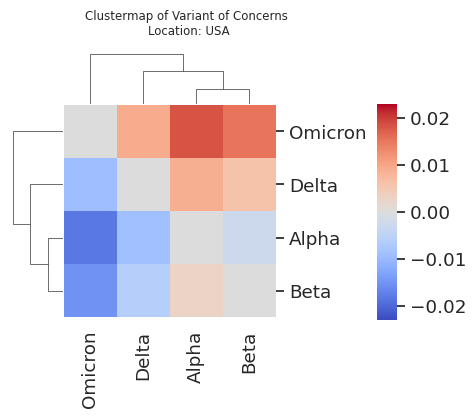

In [12]:
clustermap_obj_usa = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'], alpha_beta_usa, beta_delta_usa, delta_omicron_usa, 'USA')
combined_distance_matrix_usa = pd.DataFrame(clustermap_obj_usa.data)

### North America